# DSAIT4335 Recommender Systems
# Assignment 1: Content-based Recommendation

In this assignment, you will work to build a content-based recommendation model using different text processing methods. Then, you will apply your content-based recommendation model on a public dataset. The dataset is **MovieLens100K**, a movie recommendation dataset collected by GroupLens: https://grouplens.org/datasets/movielens/100k/.

By the end of this assignment, you will:
1. Understand the fundamental principles of content-based recommender systems
2. Develop feature extraction method (BERT)
3. Build user and item profiles from content features
4. Perform both rating prediction and top-k recommendation tasks
5. Evaluate content-based methods to understand their strengths/limitations

# Instruction

The MovieLens100K is already splitted into 80% training and 20% test sets. Along with training and test sets, movies metadata as content information is also provided.

**Expected file structure** for this assignment:   
   
   ```
   Assignment1/
   ├── training.txt
   ├── test.txt
   ├── movies.txt
   └── hw1.ipynb
   ```

**Note:** Be sure to run all cells in each section sequentially, so that intermediate variables and packages are properly carried over to subsequent cells.

**Submission:** Answer all the questions in this jupyter-notebook file. Submit this jupyter-notebook file (your answers included) to Brightspace. Change the name of this jupyter-notebook file to your name: firstname-lastname.ipynb.

# Setup

Import necessary libraries/packages.

In [1]:
%pip install --upgrade pip
%pip install transformers torch # For BERT
%pip install pandas matplotlib seaborn scikit-learn # Added myself

# you can refer https://huggingface.co/docs/transformers/en/model_doc/bert for various versions of the pre-trained model BERT

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# For BERT embeddings (install: pip install transformers torch)
print("Check the status of BERT installation:")

try:
    from transformers import AutoTokenizer, AutoModel
    import torch
    BERT_AVAILABLE = True
    print("BERT libraries loaded successfully!")
    device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
    print(f"Using device: {device}")
except ImportError:
    BERT_AVAILABLE = False
    print("BERT libraries not available. Install with: pip install transformers torch")

Check the status of BERT installation:


/opt/homebrew/Cellar/jupyterlab/4.4.7/libexec/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


BERT libraries loaded successfully!
Using device: cuda


In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import re
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Basic libraries imported successfully!")

Basic libraries imported successfully!


# 1) MovieLens100K dataset

Before building content-based recommender, we need to do exploratory data analysis to thoroughly understand our data and its content features.

Preliminary: Take a glimpse of the following dataframes to check what the training, test, and movie data files constitute.

In [84]:
# loading the training set and test set
columns_name=['user_id','item_id','rating','timestamp']
train_data = pd.read_csv('training.txt', sep='\t', names=columns_name)
test_data = pd.read_csv('test.txt', sep='\t', names=columns_name)

print(f'The training data:')
display(train_data[['user_id','item_id','rating']].head())
print(f'The shape of the training data: {train_data.shape}')
print('--------------------------------')
print(f'The test data:')
display(test_data[['user_id','item_id','rating']].head())
print(f'The shape of the test data: {test_data.shape}')
# print(test_data.shape)

The training data:


,user_id,item_id,rating
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3


The shape of the training data: (80000, 4)
--------------------------------
The test data:


,user_id,item_id,rating
0,1,6,5
1,1,10,3
2,1,12,5
3,1,14,5
4,1,17,3


The shape of the test data: (20000, 4)


In [85]:
movies = pd.read_csv('movies.txt',names=['item_id','title','genres','description'],sep='\t')
movies.head()

,item_id,title,genres,description
0,1,Toy Story (1995),"Animation, Children's, Comedy","A group of sentient toys, who pretend to be li..."
1,2,GoldenEye (1995),"Action, Adventure, Thriller","In 1986, MI6 agents James Bond and Alec Trevel..."
2,3,Four Rooms (1995),Thriller,"On New Year's Eve, bellhop Sam (Marc Lawrence)..."
3,4,Get Shorty (1995),"Action, Comedy, Drama",Chili Palmer is a Miami-based loan shark and m...
4,5,Copycat (1995),"Crime, Drama, Thriller",After giving a guest lecture on criminal psych...


### Question 1: How many users, items, and ratings are in the training set?

In [86]:
def get_data_stats(train_data):
    """
    Perform basic statistical analysis of the MovieLens100K dataset.
    """
    if train_data is None:
        print("Please load the MovieLens dataset first!")
        return
    
    n_users = 0
    n_movies = 0
    n_ratings = 0
    
    ############# Your code here ############
    n_users = len(set(train_data['user_id']))
    n_movies = len(set(train_data['item_id']))
    n_ratings = train_data['rating'].notna().sum()
    #########################################
    
    return n_users, n_movies, n_ratings

n_users, n_movies, n_ratings = get_data_stats(train_data)
print("Dataset Analysis")
print("=" * 30)
print(f"Number of Users: {n_users:,}")
print(f"Number of Movies: {n_movies:,}")
print(f"Number of Actual Ratings: {n_ratings:,}")
print("-" * 40)

Dataset Analysis
Number of Users: 943
Number of Movies: 1,650
Number of Actual Ratings: 80,000
----------------------------------------


### Question 2: What is the sparsity of the data?

In [87]:
def get_UIM_sparsity(train_data):
    # Implement the function that returns the fraction of missing data in user-item rating matrix. 
    # You can call get_data_stats(train_data) function for getting the necessary variables.
    
    sparsity = 0.0

    ############# Your code here ############
    n_users, n_movies, n_ratings = get_data_stats(train_data)
    all_possible_ratings = n_users * n_movies
    print(f"all possible ratings {all_possible_ratings}")
    print(f"given ratings {n_ratings}")
    sparsity = 1 - (n_ratings / all_possible_ratings)
    #########################################

    return sparsity

sparsity = get_UIM_sparsity(train_data)
print("Sparsity of the data is {}".format(sparsity))

all possible ratings 1555950
given ratings 80000
Sparsity of the data is 0.948584466081815


### Question 3: Create the histogram of movie title length. Set the number of bins to 20.

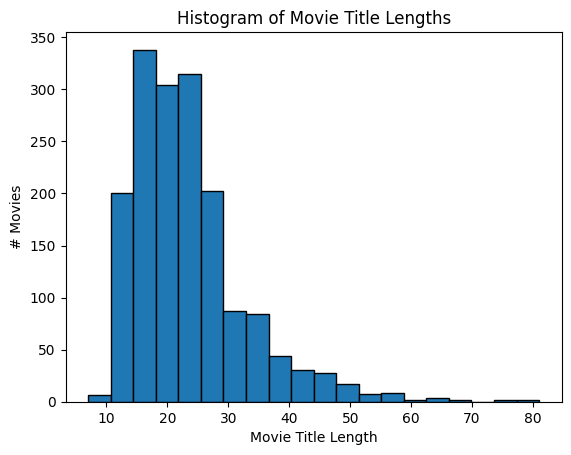

In [90]:
def hist_title_length(movies):
    # Given movies dataframe, implement the function that generates a histogram of movies title length. 
    # Hint: in histogram, x-axis shows the length of title, and y-axis shows the number of movies with the corresponding length.

    ############# Your code here ############
    titles = movies['title']
    lengths = titles.apply(lambda x : len(x))
    data = lengths.values
    
    plt.hist(data, bins=20, edgecolor="black")
    plt.xlabel("Movie Title Length")
    plt.ylabel("# Movies")
    plt.title("Histogram of Movie Title Lengths")
    plt.show()
    #########################################
    
hist_title_length(movies)

Discuss your observations.



Most movie titles have a length between 10 and 30 characters, a few are longer or shorter. The histogram shape looks close to a normal distribution.

### Question 4: Create the histogram of movie description length. Set the number of bins to 20.

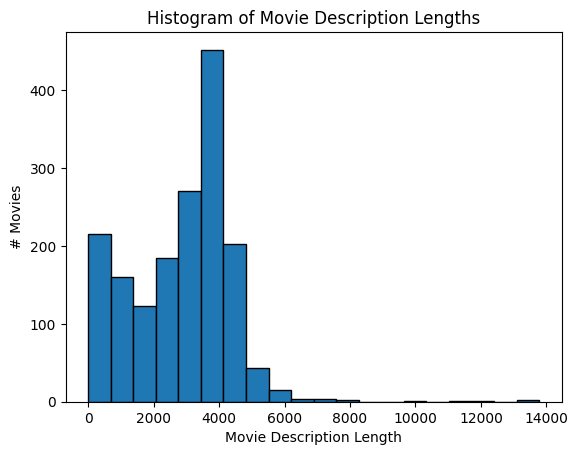

In [9]:
def hist_description_length(movies):
    # Given movies dataframe, implement the function that generates a histogram of movies description length. 
    # Hint: in histogram, x-axis shows the length of description, and y-axis shows the number of movies with the corresponding length.

    ############# Your code here ############
    titles = movies['description']
    lengths = titles.apply(lambda x : len(x))
    data = lengths.values
    
    plt.hist(data, bins=20, edgecolor="black")
    plt.xlabel("Movie Description Length")
    plt.ylabel("# Movies")
    plt.title("Histogram of Movie Description Lengths")
    plt.show()
    #########################################
    
hist_description_length(movies)

Discuss your observations.

Nearly all descriptions are between 0 and 5400 characters, we see two peaks in the first and sixth bins. The histogram shape does not look familiar to me. We do see that there are generally far more characters in movie descriptions than titles.

# 2) Deriving content representation with BERT

BERT (Bidirectional Encoder Representations from Transformers) provides rich, contextual embeddings that can capture semantic meaning. See [Devlin, Jacob, et al. "Bert: Pre-training of deep bidirectional transformers for language understanding." NAACL-HLT 2 2019](https://aclanthology.org/N19-1423.pdf) for more details.

In [8]:
def create_bert_embeddings(content):
    """
    Generate BERT embeddings for movie content.

    Args:
        content: Content of items

    Returns:
        numpy.ndarray: BERT embeddings matrix
    """
    if not BERT_AVAILABLE:
        print("BERT libraries not available. Install with: pip install transformers torch")
        return None

    if content is None:
        return None

    if isinstance(content, pd.Series):
        content = content.fillna("").astype(str).tolist()
    elif isinstance(content, np.ndarray):
        content = content.astype(str).tolist()

    model_name = 'distilbert-base-uncased'

    print(f"Loading BERT model: {model_name}")

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    # Set device (GPU if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using cuda or cpu: {device}")
    model.to(device)
    model.eval()

    print(f"Using device: {device}")

    # Generate embeddings in batches
    batch_size = 32  # Adjust based on available memory
    emb = []

    for i in range(0, len(content), batch_size):
        if i % (batch_size * 10) == 0:
            print(f"Processing batch {i//batch_size + 1}/{len(content)//batch_size + 1}")

        batch_texts = content[i:i + batch_size]

        # Tokenize batch
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors='pt'
        )

        # Move to device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Generate embeddings
        with torch.no_grad():
            outputs = model(**inputs)

            # Use [CLS] token embedding (first token)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            emb.extend(batch_embeddings)

    emb = np.array(emb)

    print(f"BERT embeddings generated: {emb.shape}")
    print(f"Embedding dimension: {emb.shape[1]}")

    return emb

You can get the content representation using BERT as follows:

In [9]:
# Sample content
sample_content = ['aa','ab','ac','bc']

# Generate BERT embeddings (this may take several minutes)
print("Generating BERT embeddings...")
bert_embeddings = create_bert_embeddings(sample_content)

if bert_embeddings is not None:
    print("BERT embeddings created successfully!")
else:
    print("BERT embeddings not available. Continuing with TF-IDF only.")

Generating BERT embeddings...
Loading BERT model: distilbert-base-uncased
Using cuda or cpu: cpu
Using device: cpu
Processing batch 1/1
BERT embeddings generated: (4, 768)
Embedding dimension: 768
BERT embeddings created successfully!


### Question 5: Derive the representation of items for three types of content: 
    1) title + genres 
    2) description 
    3) title + genres + description

In [10]:
# Implement code to derive the content representation for title and genres. Concatenate the two content as: title + ' ' + genres
item_emb_titlegenres = None
############# Your code here ############
titles_concat_genres = movies['title'] + " " + movies['genres']
item_emb_titlegenres = create_bert_embeddings(titles_concat_genres)
#########################################

# Implement code to derive the content representation for description.
item_emb_description = None
############# Your code here ############
item_emb_description = create_bert_embeddings(movies['description'].values)
#########################################

# Implement code to derive the content representation for title, genres, and description. Concatenate the two content as: title + ' ' + genres + '' + description
item_emb_full = None
############# Your code here ############
combined = movies['title'] + ' ' + movies['genres'] + ' ' + movies['description'] 
item_emb_full = create_bert_embeddings(combined)
#########################################

Loading BERT model: distilbert-base-uncased
Using cuda or cpu: cpu
Using device: cpu
Processing batch 1/53
Processing batch 11/53
Processing batch 21/53
Processing batch 31/53
Processing batch 41/53
Processing batch 51/53
BERT embeddings generated: (1682, 768)
Embedding dimension: 768
Loading BERT model: distilbert-base-uncased
Using cuda or cpu: cpu
Using device: cpu
Processing batch 1/53
Processing batch 11/53
Processing batch 21/53
Processing batch 31/53
Processing batch 41/53
Processing batch 51/53
BERT embeddings generated: (1682, 768)
Embedding dimension: 768
Loading BERT model: distilbert-base-uncased
Using cuda or cpu: cpu
Using device: cpu
Processing batch 1/53
Processing batch 11/53
Processing batch 21/53
Processing batch 31/53
Processing batch 41/53
Processing batch 51/53
BERT embeddings generated: (1682, 768)
Embedding dimension: 768


### Question 6: What is the embedding of item_id=100?

In [11]:
def get_item_emb(item_id, content_type):
    # Implement the function that given content type (title+genres, description, or title+genres+description) returns the embedding derived for the corresponding item_id. 
    # Hint1: keep in mind that item_id in the data starts from 1, but in the embedding variable it starts from 0, e.g., item_id 100 corresponds to index 99 in embedding variable..
    # Hint2: use if-else conditions to return the embedding for the requested content types.
    # Hint3: use the global variables (embeddings) already computed in previous cells.

    emb = None
    
    ############# Your code here ############
    index = item_id - 1
    if content_type == 'title_genres':
        emb = item_emb_titlegenres[index]
    elif content_type == 'description':
        emb = item_emb_description[index]
    elif content_type == 'full':
        emb = item_emb_full[index]
    else:
        raise ValueError(f"Unknown content type: {content_type}")
    #########################################

    return emb
    
item_id = 100
print('Embedding representation for content type = title+genres:')
print(get_item_emb(item_id, 'title_genres'))
print('------------------------------------------')
print('Embedding representation for content type = description:')
print(get_item_emb(item_id, 'description'))
print('------------------------------------------')
print('Embedding representation for content type = full:')
print(get_item_emb(item_id, 'full'))
print('------------------------------------------')

Embedding representation for content type = title+genres:
[-1.33968890e-01 -9.01784748e-02 -1.27716705e-01 -1.31242618e-01
 -3.00813280e-02  1.16647087e-01  2.68211275e-01  1.28216103e-01
 -2.02164222e-02 -5.45809790e-02  1.50338635e-01 -5.03517427e-02
 -1.71943143e-01  3.98922324e-01  3.19539338e-01  3.08139890e-01
 -1.24050990e-01  3.27948838e-01  1.63815260e-01 -1.64277077e-01
 -1.18869163e-01 -2.46316582e-01  1.83683887e-01  9.05875713e-02
 -3.29116583e-02  1.50853336e-01 -3.94599289e-01 -9.15593430e-02
  1.46123439e-01  2.79693961e-01  2.88072340e-02  8.70803371e-02
 -1.64137527e-01 -6.84376284e-02  3.54835927e-01  1.68893076e-02
  1.22078300e-01 -1.09478354e-01 -5.38687631e-02 -8.63625705e-02
  2.87261233e-02  7.36704245e-02  2.03959435e-01 -1.56151816e-01
  8.09048563e-02 -8.71453807e-02 -2.65358257e+00 -2.31110707e-01
 -2.65956998e-01 -7.23348781e-02  2.97734559e-01  1.20156951e-01
  1.21809959e-01  1.11444049e-01  3.60954463e-01  5.76821327e-01
 -9.38286409e-02  8.00885335e-02

# 3) User profile construction

### Question 7: What are the embeddings and ratings of interacted items by user_id=100?

In [12]:
def get_interacted_items_embs_rating(train_data, user_id, content_type):
    # Implement the function that given content type (title+genres, description, or title+genres+description) returns the embeddings and ratings of interacted items by user_id=100. 
    # Hint1: use train_data to retrieve the item_ids that target user (user_id=100 in this example) interacted, then pass these item_ids to function previously implemented to retrieve the embeddings and ratings.

    embs, ratings = [], []
    
    ############# Your code here ############
    mask = train_data['user_id'].eq(user_id)
    user_rows = train_data.loc[mask, ['item_id', 'rating']]
    item_ids = user_rows['item_id']
    embs = item_ids.apply(lambda x : get_item_emb(x, content_type)).values
    ratings = user_rows['rating'].values
    #########################################

    return embs, ratings
    
user_id = 100
print('Embeddings and ratings of interacted items by user_id=100 for content type = title+genres:')
print(get_interacted_items_embs_rating(train_data, user_id, 'title_genres'))
print('------------------------------------------')
print('Embeddings and ratings of interacted items by user_id=100 for content type = description:')
print(get_interacted_items_embs_rating(train_data, user_id, 'description'))
print('------------------------------------------')
print('Embeddings and ratings of interacted items by user_id=100 for content type = full:')
print(get_interacted_items_embs_rating(train_data, user_id, 'full'))
print('------------------------------------------')

Embeddings and ratings of interacted items by user_id=100 for content type = title+genres:
(array([array([-1.10551119e-01, -7.49559775e-02, -2.26197615e-01, -1.45411089e-01,
              -1.07524954e-02,  1.18970938e-01,  1.49337113e-01,  2.11916864e-01,
              -8.58947709e-02,  1.91680491e-02,  6.93989992e-02, -1.28075659e-01,
              -6.95622861e-02,  2.59627372e-01,  2.46748358e-01,  1.54867902e-01,
              -1.78491175e-01,  1.92843318e-01,  1.00374021e-01, -1.94543600e-01,
              -1.80487454e-01, -2.29439378e-01,  1.18793018e-01,  1.36366114e-01,
              -1.24470927e-02,  1.01595685e-01, -1.72738642e-01,  8.16610977e-02,
               1.84626192e-01,  1.74651414e-01,  5.71560524e-02,  1.30099371e-01,
              -1.81853876e-01, -1.11466937e-01,  2.43417382e-01, -8.62910599e-02,
               1.54848799e-01, -9.63721797e-02, -3.63760442e-02,  3.50997746e-02,
               3.31873484e-02,  1.02180861e-01,  1.62405714e-01, -1.32392153e-01,
      

### Question 8: Derive the representation for user_id=100 using the following aggregation methods:
1. **avg:** Average representation of interacted item 
2. **weighted_avg:** Weighted average representation of interacted item using rating values
3. **avg_pos:** Average representation of positively interacted item (ratings >= 4)

In [13]:
def get_user_emb(train_data, user_id, content_type, aggregation_method):
    # Implement the function that given content type (title+genres, description, or title+genres+description) and aggregation method (avg, weighted_avg, avg_pos) returns the representation of a user. 
    # Hint1: use the previsouly implemented items for retrieving ratings and representation of interacted items by a user.

    emb = []
    
    ############# Your code here ############
    embs, ratings = get_interacted_items_embs_rating(train_data, user_id, content_type)
    if aggregation_method == 'avg':
        emb = np.mean(embs, axis=0)
    elif aggregation_method == 'weighted_avg':
        weighted = [e * r for e, r in zip(embs, ratings)]
        rating_sum = np.sum(ratings)
        emb = np.sum(weighted, axis=0) / rating_sum
    elif aggregation_method == 'avg_pos':
        pos_embs = [e for e, r in zip(embs, ratings) if r >= 4]
        emb = np.mean(pos_embs, axis=0)
    else:
        raise ValueError(f'Invalid aggregation method: {aggregation_method}')    
    #########################################

    return emb
    
user_id = 100
content_type, aggregation_method = 'full', 'avg' # alternatives are content_type={title_genres,description,full} and aggregation_method={avg,weighted_avg,avg_pos}
print('Embeddings of user_id=100 for content type '+content_type+' by aggregation method '+aggregation_method+':')
print(get_user_emb(train_data, user_id, content_type, aggregation_method))

Embeddings of user_id=100 for content type full by aggregation method avg:
[-3.77594709e-01 -1.62529156e-01 -2.09185511e-01 -2.44604394e-01
  1.60393208e-01  3.55566181e-02  3.65352660e-01  2.70110220e-02
 -6.46177912e-04 -2.21369579e-01 -9.99603868e-02  2.31478885e-02
 -1.80722773e-01  2.96081334e-01 -8.29827636e-02  1.43453717e-01
  1.55283332e-01  2.35295862e-01  1.67761579e-01 -4.14667390e-02
  5.51841259e-02 -2.42448270e-01  2.64884233e-01  3.63100857e-01
  6.64631650e-03  2.56049633e-02 -1.33248806e-01 -3.82726602e-02
 -9.05935932e-03  1.32687181e-01  1.40577391e-01  5.12599945e-02
 -5.17637767e-02 -4.51556325e-01  3.91069427e-02 -1.01737842e-01
  8.39059651e-02 -4.78987880e-02  7.95425773e-02  2.78782099e-01
  2.07495876e-04  1.23829544e-01 -1.82174638e-01 -1.16067827e-01
  6.78641275e-02 -3.27166110e-01 -3.30903840e+00 -8.06847289e-02
 -9.30583477e-02 -2.10115910e-01  3.48131418e-01  1.98958889e-01
  1.32903084e-01  2.29476735e-01  3.23887110e-01  2.07131669e-01
 -3.34604740e-0

# 4) Content-based recommendation

Predict the rating for a user-item pair. Use dot product between user and item ebmeddings to predict the score.

### Question 9: What is the predicted score for user_id=100 and item_id=266?

**Note:** The predicted score might not be in the interval [1,5]. In the next part, after predicting the ratings for all user-item pair, the predictions will be normalized.

In [14]:
def get_user_item_prediction(train_data, user_id, item_id, content_type, aggregation_method):
    # Implement the function that given content type and aggregation method returns the predicted rating for a user-item pair. 
    # Hint1: use the previsouly implemented functions for retrieving the embeddings and then compute the dot product of user and item embeddings.

    pred_rating = 0.0
    
    ############# Your code here ############
    user_emb = get_user_emb(train_data, user_id, content_type, aggregation_method)
    item_emb = get_item_emb(item_id, content_type)
    pred_rating = np.dot(user_emb, item_emb)
    #########################################

    return pred_rating
    
user_id, item_id = 100, 266
content_type, aggregation_method = 'full', 'avg' # alternatives are content_type={title_genres,description,full} and aggregation_method={avg,weighted_avg,avg_pos}
print('Predicted score for user_id=100 and item_id=266 for content type '+content_type+' and aggregation method '+aggregation_method+':')
print(get_user_item_prediction(train_data, user_id, item_id, content_type, aggregation_method))

Predicted score for user_id=100 and item_id=266 for content type full and aggregation method avg:
142.68707


# 5) Metrics

For this part, refer to the lecture on "Evaluation of Recommender Systems" where different metrics are described.

### Question 10: Implement MAE, MSE, and RMSE for rating prediction task.

In [21]:
def MAE(actual_ratings, pred_ratings):
    # Implement a function that computes MAE error between actual ratings and predicted ratings. 
    # Note that actual_ratings and pred_ratings are lists.
    
    result = 0.0
    
    ############# Your code here ############
    absolute_errors = [np.abs(a - p) for a, p in zip(actual_ratings, pred_ratings)]
    result = np.sum(absolute_errors)/len(actual_ratings)
    #########################################

    return result

def MSE(actual_rating, pred_rating):
    # Implement a function that computes MSE error between actual ratings and predicted ratings. 
    # Note that actual_ratings and pred_ratings are lists.
    
    result = 0.0
    
    ############# Your code here ############
    squared_errors = [(a - p) ** 2 for a, p in zip(actual_rating, pred_rating)]
    result = np.sum(squared_errors)/len(actual_rating)
    #########################################

    return result

def RMSE(actual_rating, pred_rating):
    # Implement a function that computes RMSE error between actual ratings and predicted ratings. 
    # Note that actual_ratings and pred_ratings are lists.
    
    result = 0.0
    
    ############# Your code here ############
    result = np.sqrt(MSE(actual_rating, pred_rating))
    #########################################

    return result

# Evaluating with examples (from slides)
test_gt = [4, 4, 1, 4]
test_pred = [3.8, 4.3, 2.9, 4.9]

print(f"MAE: {MAE(test_gt, test_pred)}, should be: 0.825")
print(f"MSE: {MSE(test_gt, test_pred)}, should be: 1.138")
print(f"RMSE: {RMSE(test_gt, test_pred)}, should be: 1.067")

MAE: 0.8250000000000001, should be: 0.825
MSE: 1.1375000000000002, should be: 1.138
RMSE: 1.0665364503850772, should be: 1.067


### Question 11: Implement Precision, Recall, NDCG, MRR, and MAP for ranking task.

In [82]:
def Precision(ground_truth, rec_list):
    # Implement a function that computes Precision across ground truth data and recommendation list generated for each user. 
    # Note that ground_truth and rec_list contain the list of items for all users, e.g., 2-dimensional arrays.
    result = 0.0
    
    ############# Your code here ############
    # Fraction of relevant items retrieved out of all items retrieved
    N = len(ground_truth)
    for gt_items, rec_items in zip(ground_truth, rec_list):
        relevant_items_retrieved = set(gt_items).intersection(set(rec_items))
        result += len(relevant_items_retrieved)/float(len(rec_items))

    result /= float(N)
    #########################################

    return result * 100

def Recall(ground_truth, rec_list):
    # Implement a function that computes Recall across ground truth data and recommendation list generated for each user. 
    # Note that ground_truth and rec_list contain the list of items for all users, e.g., 2-dimensional arrays.
    
    result = 0.0
    
    ############# Your code here ############
    # Fraction of relevant items retrieved out of all relevant items
    recalls = []
    for gt_items, rec_items in zip(ground_truth, rec_list):
        if len(gt_items) == 0:
            continue
        gt_set = set(gt_items)
        rec_set = set(rec_items)
        hits = len(gt_set.intersection(rec_set))
        recalls.append(hits / len(gt_set))

    result = sum(recalls) / len(recalls) if recalls else 0.0
    
    return result * 100


def NDCG(ground_truth, rec_list):
    # Implement a function that computes NDCG across ground truth data and recommendation list generated for each user. 
    # Note that ground_truth and rec_list contain the list of items for all users, e.g., 2-dimensional arrays.
    
    result = 0.0
    
    ############# Your code here ############
    # For each user calculate NDCG and take mean
    for gt_items, rec_items in zip(ground_truth, rec_list):
        K = len(rec_items)
        # Calculate DCG
        DCG = 0
        for i in range(K):
            numerator = 1 if rec_items[i] in gt_items else 0 
            denominator = np.log2(i + 2)
            DCG += numerator / denominator
        # IDCG (ideal is all relevant items up to K)
        ideal_len = min(K, len(gt_items))
        if ideal_len == 0:
            ndcg = 0.0
        else:
            IDCG = sum(1.0 / np.log2(i + 2) for i in range(ideal_len))
            ndcg = DCG / IDCG
        # Calculate NDCG
        result += ndcg
        
    # Take mean over all users
    result /= float(len(ground_truth))
    
    #########################################
    
    return result

def MRR(ground_truth, rec_list):
    # Implement a function that computes MRR across ground truth data and recommendation list generated for each user. 
    # Note that ground_truth and rec_list contain the list of items for all users, e.g., 2-dimensional arrays.
    
    result = 0.0
    
    ############# Your code here ############
    # For each user calculate MRR and take mean
    for gt_items, rec_items in zip(ground_truth, rec_list):
        for i in range(len(rec_items)):
            rank = i + 1
            # First relevant item found
            if rec_items[i] in gt_items:
                result += 1 / float(rank)
                break
            elif rank == len(rec_items):
                # No relevant items found
                result += 0
    if len(rec_list) == 0:
        return 0.0
    result /= len(rec_list)
    #########################################

    return result

def MAP(ground_truth, rec_list):
    # Implement a function that computes MAP across ground truth data and recommendation list generated for each user. 
    # Note that ground_truth and rec_list contain the list of items for all users, e.g., 2-dimensional arrays.
    
    result = 0.0
    
    ############# Your code here ############
    # Calculate AP for a user and take mean
    for gt_items, rec_items in zip(ground_truth, rec_list):
        S = len(rec_items)
        AP = 0.0
        n = 0
        for k in range(1, S + 1):
            rec_k = rec_items[:k]
            if rec_items[k - 1] not in gt_items:
                continue
            precision = Precision([gt_items], [rec_k]) / 100
            AP += precision
            n += 1
        if (n > 0):
            result += AP / n
    # Take mean of AP across users to get MAP
    if len(rec_list) == 0:
        return 0.0
    result /= len(rec_list)
    #########################################

    return result

# Evaluating with examples (from slides)
gt = [
    [2, 3],
    [1, 2, 3, 5, 7],
    [3, 4, 6],
    [1, 2, 3, 4, 5, 6]
]
rec = [
    [1, 3, 4, 6],
    [2, 3, 4, 5],
    [1, 2, 5, 7],
    [3, 4, 5, 6]
]
print(f"Precision: {Precision(gt, rec)}, should be: 50%")
print(f"Recall: {Recall(gt, rec)}, should be 44%")

Precision: 50.0, should be: 50%
Recall: 44.166666666666664, should be 44%


# 6) Evaluation of content-based recommender for rating prediction task

### Question 12: Predict the ratings for all user-item pairs in test set and compute MAE, MSE, and RMSE. Discuss your observations.

In [17]:
# For each row, predict the rating
def predict_ratings(test_data, train_data, content_type, aggregation_method):
    data = test_data.copy()
    data["predicted_rating"] = data.apply(
        lambda row: get_user_item_prediction(
            train_data, row["user_id"], row["item_id"], content_type, aggregation_method
        ),
        axis=1
    )
    preds = data['predicted_rating'].to_numpy(dtype=float)
    min_val = np.min(preds)
    max_val = np.max(preds)
    normalize = lambda pred : 1 + (pred - min_val) * (4 / (max_val - min_val))
    data["predicted_rating"] = data["predicted_rating"].apply(normalize)

    return data
    
def evaluate_rating_prediction(train_data, test_data, content_type, aggregation_method):
    # Implement a function that first computes the representation of users and then predicts the rating for each user-item pair. Finally, call the implemented metrics to measure the error.
    # Hint: the reason for pre-computing the representation of all users is to speed up the experiments and to avoid too many unnecessary computations.
    # Note: Make sure to map the predicted score into [1,5] interval. The prediction from content-based model may not necessarily be in 5-star rating scale.

    # here we compute the representation of users
    users_emb = []
    users = list(train_data['user_id'].unique())
    for user in tqdm(users):
        users_emb.append(get_user_emb(train_data, user, content_type, aggregation_method))

    print('Computing the representation of users is done!')
    
    ############# Your code here ############
    predictions = []
    actual_ratings = []
    data = predict_ratings(test_data, train_data, content_type, aggregation_method)
    actual_ratings = data['rating'].values
    pred_ratings = data['predicted_rating'].values
    #########################################

    # Given predicted ratings, map them into [1,5] interval using -> 1 + (pred - min_val) * (4 / (max_val - min_val))
    ############# Your code here ############
    # Normalization already in predict_ratings method
    #########################################

    mae_value, mse_value, rmse_value = 0.0, 0.0, 0.0

    # compute the metrics: MAE, MSE, RMSE 
    ############# Your code here ############
    mae_value = MAE(actual_ratings, pred_ratings)
    mse_value = MSE(actual_ratings, pred_ratings)
    rmse_value = RMSE(actual_ratings, pred_ratings)
    #########################################

    return mae_value, mse_value, rmse_value

print('Performance of content-based recommender for content type = title+genres and aggregation method = avg:')
mae_value, mse_value, rmse_value = evaluate_rating_prediction(train_data, test_data, 'title_genres', 'avg')
print('MAE='+str(round(mae_value,5))+', MSE='+str(round(mse_value,5))+', RMSE='+str(round(rmse_value,5)))
print('------------------------------------------')
print('Performance of content-based recommender for content type = description and aggregation method = avg:')
mae_value, mse_value, rmse_value = evaluate_rating_prediction(train_data, test_data, 'description', 'avg')
print('MAE='+str(round(mae_value,5))+', MSE='+str(round(mse_value,5))+', RMSE='+str(round(rmse_value,5)))
print('------------------------------------------')
print('Performance of content-based recommender for content type = full and aggregation method = avg:')
mae_value, mse_value, rmse_value = evaluate_rating_prediction(train_data, test_data, 'full', 'avg')
print('MAE='+str(round(mae_value,5))+', MSE='+str(round(mse_value,5))+', RMSE='+str(round(rmse_value,5)))
print('------------------------------------------')
print('Performance of content-based recommender for content type = title+genres and aggregation method = weighted_avg:')
mae_value, mse_value, rmse_value = evaluate_rating_prediction(train_data, test_data, 'title_genres', 'weighted_avg')
print('MAE='+str(round(mae_value,5))+', MSE='+str(round(mse_value,5))+', RMSE='+str(round(rmse_value,5)))
print('------------------------------------------')
print('Performance of content-based recommender for content type = description and aggregation method = weighted_avg:')
mae_value, mse_value, rmse_value = evaluate_rating_prediction(train_data, test_data, 'description', 'weighted_avg')
print('MAE='+str(round(mae_value,5))+', MSE='+str(round(mse_value,5))+', RMSE='+str(round(rmse_value,5)))
print('------------------------------------------')
print('Performance of content-based recommender for content type = full and aggregation method = weighted_avg:')
mae_value, mse_value, rmse_value = evaluate_rating_prediction(train_data, test_data, 'full', 'weighted_avg')
print('MAE='+str(round(mae_value,5))+', MSE='+str(round(mse_value,5))+', RMSE='+str(round(rmse_value,5)))
print('------------------------------------------')
print('Performance of content-based recommender for content type = title+genres and aggregation method = avg_pos:')
mae_value, mse_value, rmse_value = evaluate_rating_prediction(train_data, test_data, 'title_genres', 'avg_pos')
print('MAE='+str(round(mae_value,5))+', MSE='+str(round(mse_value,5))+', RMSE='+str(round(rmse_value,5)))
print('------------------------------------------')
print('Performance of content-based recommender for content type = description and aggregation method = avg_pos:')
mae_value, mse_value, rmse_value = evaluate_rating_prediction(train_data, test_data, 'description', 'avg_pos')
print('MAE='+str(round(mae_value,5))+', MSE='+str(round(mse_value,5))+', RMSE='+str(round(rmse_value,5)))
print('------------------------------------------')
print('Performance of content-based recommender for content type = full and aggregation method = avg_pos:')
mae_value, mse_value, rmse_value = evaluate_rating_prediction(train_data, test_data, 'full', 'avg_pos')
print('MAE='+str(round(mae_value,5))+', MSE='+str(round(mse_value,5))+', RMSE='+str(round(rmse_value,5)))
print('------------------------------------------')

Performance of content-based recommender for content type = title+genres and aggregation method = avg:


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|███████████████████████████████████████| 943/943 [00:00<00:00, 2925.51it/s]


Computing the representation of users is done!
MAE=1.0772, MSE=1.88283, RMSE=1.37216
------------------------------------------
Performance of content-based recommender for content type = description and aggregation method = avg:


100%|███████████████████████████████████████| 943/943 [00:00<00:00, 3362.22it/s]


Computing the representation of users is done!
MAE=1.05055, MSE=1.59284, RMSE=1.26208
------------------------------------------
Performance of content-based recommender for content type = full and aggregation method = avg:


100%|███████████████████████████████████████| 943/943 [00:00<00:00, 3258.32it/s]


Computing the representation of users is done!
MAE=1.01178, MSE=1.47789, RMSE=1.21568
------------------------------------------
Performance of content-based recommender for content type = title+genres and aggregation method = weighted_avg:


100%|███████████████████████████████████████| 943/943 [00:00<00:00, 2301.51it/s]


Computing the representation of users is done!
MAE=1.0366, MSE=1.73278, RMSE=1.31635
------------------------------------------
Performance of content-based recommender for content type = description and aggregation method = weighted_avg:


100%|███████████████████████████████████████| 943/943 [00:00<00:00, 2351.50it/s]


Computing the representation of users is done!
MAE=1.08258, MSE=1.68577, RMSE=1.29837
------------------------------------------
Performance of content-based recommender for content type = full and aggregation method = weighted_avg:


100%|███████████████████████████████████████| 943/943 [00:00<00:00, 2309.47it/s]


Computing the representation of users is done!
MAE=1.03539, MSE=1.54048, RMSE=1.24116
------------------------------------------
Performance of content-based recommender for content type = title+genres and aggregation method = avg_pos:


100%|███████████████████████████████████████| 943/943 [00:00<00:00, 3301.58it/s]


Computing the representation of users is done!
MAE=1.02561, MSE=1.6921, RMSE=1.30081
------------------------------------------
Performance of content-based recommender for content type = description and aggregation method = avg_pos:


100%|███████████████████████████████████████| 943/943 [00:00<00:00, 3085.12it/s]


Computing the representation of users is done!
MAE=1.09505, MSE=1.7212, RMSE=1.31195
------------------------------------------
Performance of content-based recommender for content type = full and aggregation method = avg_pos:


100%|███████████████████████████████████████| 943/943 [00:00<00:00, 3348.60it/s]


Computing the representation of users is done!
MAE=1.04216, MSE=1.56088, RMSE=1.24935
------------------------------------------


Discuss your observations.

Since we do not yet have a baseline to compare the content-based recommender with, we can only compare the results between different content types and aggregation methods.

The best performing combination of content-types and aggregation methods across all metrics is the content-type full and aggregation method average, while there is no clear "worst". We can also see that for 2/3 aggregation methods, content-type full performs best across all metrics. A reason for this might be that more information can allow for better comparisons between items. However, this might not be true in all cases, as some information might not be useful in determining the relevance of an item and can thus negatively impact the performance of the system.

### Question 13: Generate recommendation list of size 10 for each user and compute Precision, Recall, NDCG, MRR, and MAP. Discuss your observations.

In [81]:
def evaluate_rating_prediction(train_data, test_data, content_type, aggregation_method):
    # Implement a function that first computes the representation of users and then predicts the relevance score of all items for each user. Next, return 10 unseen items with the highest predicted relevance score for each user as the recommendation list. Finally, call the implemented metrics to measure accuracy of recommendation.
    # Hint: the reason for pre-computing the representation of all users is to speed up the experiments and to avoid too many unnecessary computations.
    # Hint: no normalization is needed.

    # here we compute the representation of users
    users_emb = []
    users = list(train_data['user_id'].unique())
    for user in users:
        users_emb.append(get_user_emb(train_data, user, content_type, aggregation_method))

    ground_truth, rec_list = [], []
    
    ############# Your code here ############
    data_with_predictions = predict_ratings(test_data, train_data, content_type, aggregation_method)
    K = 10
    for user_id in list(test_data['user_id'].unique()):
        user_data = data_with_predictions.where(data_with_predictions['user_id'] == user_id)
        gt = user_data.where(user_data['rating'] >= 4)['item_id'].values
        # Recommend K unseen items (items not interacted by the target user in training data) to each user
        seen_items = train_data.loc[train_data['user_id'] == user_id, 'item_id'].values
        unseen_items = user_data.loc[~user_data['item_id'].isin(seen_items)]
        top_k_rec = unseen_items.nlargest(K, 'predicted_rating')
        ground_truth.append(gt)
        rec_list.append(top_k_rec['item_id'].values)
    #########################################

    precision_value, recall_value, ndcg_value, mrr_value, map_value = 0.0, 0.0, 0.0, 0.0, 0.0

    # compute the metrics: Precision, Recall, NDCG, MRR, MAP
    ############# Your code here ############
    precision_value = Precision(ground_truth, rec_list)
    recall_value = Recall(ground_truth, rec_list)
    ndcg_value = NDCG(ground_truth, rec_list)
    mrr_value = MRR(ground_truth, rec_list)
    map_value = MAP(ground_truth, rec_list)
    #########################################

    return precision_value, recall_value, ndcg_value, mrr_value, map_value

print('Performance of content-based recommender for content type = title+genres and aggregation method = avg:')
precision_value, recall_value, ndcg_value, mrr_value, map_value = evaluate_rating_prediction(train_data, test_data, 'title_genres', 'avg')
print('Precision='+str(round(precision_value,5))+', Recall='+str(round(recall_value,5))+', NDCG='+str(round(ndcg_value,5))+', MRR='+str(round(mrr_value,5))+', MAP='+str(round(map_value,5)))
print('------------------------------------------')
print('Performance of content-based recommender for content type = description and aggregation method = avg:')
precision_value, recall_value, ndcg_value, mrr_value, map_value = evaluate_rating_prediction(train_data, test_data, 'description', 'avg')
print('Precision='+str(round(precision_value,5))+', Recall='+str(round(recall_value,5))+', NDCG='+str(round(ndcg_value,5))+', MRR='+str(round(mrr_value,5))+', MAP='+str(round(map_value,5)))
print('------------------------------------------')
print('Performance of content-based recommender for content type = full and aggregation method = avg:')
precision_value, recall_value, ndcg_value, mrr_value, map_value = evaluate_rating_prediction(train_data, test_data, 'full', 'avg')
print('Precision='+str(round(precision_value,5))+', Recall='+str(round(recall_value,5))+', NDCG='+str(round(ndcg_value,5))+', MRR='+str(round(mrr_value,5))+', MAP='+str(round(map_value,5)))
print('------------------------------------------')
print('Performance of content-based recommender for content type = title+genres and aggregation method = weighted_avg:')
precision_value, recall_value, ndcg_value, mrr_value, map_value = evaluate_rating_prediction(train_data, test_data, 'title_genres', 'weighted_avg')
print('Precision='+str(round(precision_value,5))+', Recall='+str(round(recall_value,5))+', NDCG='+str(round(ndcg_value,5))+', MRR='+str(round(mrr_value,5))+', MAP='+str(round(map_value,5)))
print('------------------------------------------')
print('Performance of content-based recommender for content type = description and aggregation method = weighted_avg:')
precision_value, recall_value, ndcg_value, mrr_value, map_value = evaluate_rating_prediction(train_data, test_data, 'description', 'weighted_avg')
print('Precision='+str(round(precision_value,5))+', Recall='+str(round(recall_value,5))+', NDCG='+str(round(ndcg_value,5))+', MRR='+str(round(mrr_value,5))+', MAP='+str(round(map_value,5)))
print('------------------------------------------')
print('Performance of content-based recommender for content type = full and aggregation method = weighted_avg:')
precision_value, recall_value, ndcg_value, mrr_value, map_value = evaluate_rating_prediction(train_data, test_data, 'full', 'weighted_avg')
print('Precision='+str(round(precision_value,5))+', Recall='+str(round(recall_value,5))+', NDCG='+str(round(ndcg_value,5))+', MRR='+str(round(mrr_value,5))+', MAP='+str(round(map_value,5)))
print('------------------------------------------')
print('Performance of content-based recommender for content type = title+genres and aggregation method = avg_pos:')
precision_value, recall_value, ndcg_value, mrr_value, map_value = evaluate_rating_prediction(train_data, test_data, 'title_genres', 'avg_pos')
print('Precision='+str(round(precision_value,5))+', Recall='+str(round(recall_value,5))+', NDCG='+str(round(ndcg_value,5))+', MRR='+str(round(mrr_value,5))+', MAP='+str(round(map_value,5)))
print('------------------------------------------')
print('Performance of content-based recommender for content type = description and aggregation method = avg_pos:')
precision_value, recall_value, ndcg_value, mrr_value, map_value = evaluate_rating_prediction(train_data, test_data, 'description', 'avg_pos')
print('Precision='+str(round(precision_value,5))+', Recall='+str(round(recall_value,5))+', NDCG='+str(round(ndcg_value,5))+', MRR='+str(round(mrr_value,5))+', MAP='+str(round(map_value,5)))
print('------------------------------------------')
print('Performance of content-based recommender for content type = full and aggregation method = avg_pos:')
precision_value, recall_value, ndcg_value, mrr_value, map_value = evaluate_rating_prediction(train_data, test_data, 'full', 'avg_pos')
print('Precision='+str(round(precision_value,5))+', Recall='+str(round(recall_value,5))+', NDCG='+str(round(ndcg_value,5))+', MRR='+str(round(mrr_value,5))+', MAP='+str(round(map_value,5)))
print('------------------------------------------')

Performance of content-based recommender for content type = title+genres and aggregation method = avg:
Precision=55.68627, Recall=0.02784, NDCG=0.56627, MRR=0.7363, MAP=0.68074
------------------------------------------
Performance of content-based recommender for content type = description and aggregation method = avg:
Precision=57.51634, Recall=0.02876, NDCG=0.59219, MRR=0.78172, MAP=0.71125
------------------------------------------
Performance of content-based recommender for content type = full and aggregation method = avg:
Precision=56.73203, Recall=0.02837, NDCG=0.57789, MRR=0.75805, MAP=0.69101
------------------------------------------
Performance of content-based recommender for content type = title+genres and aggregation method = weighted_avg:
Precision=55.86057, Recall=0.02793, NDCG=0.56779, MRR=0.73726, MAP=0.68223
------------------------------------------
Performance of content-based recommender for content type = description and aggregation method = weighted_avg:
Precis

Discuss your observations.

Again, we do not yet have a baseline to compare the results of this experiment to, so we follow the same approach where we compare the performance between different content-types and aggregation methods for different metrics.

For all metrics and aggregation methods, we see that content type description leads to the highest scores. This gives an indication that in this case, the addition of genres and titles does not lead to more relevant recommendations, meaning this extra information actually adds noise.

Furthermore, the recall score seems very low. My hypothesis is that the ground truth list is typically far larger than the list of recommended items for a user, leading to a low fraction of relevant results retrieved out of all relevant results.

# Extended experiments

### Question 14: Implement a baseline for rating prediction task that returns average rating of target item as the predicted rating. 

For example, for a user u and item i, the prediction is the average of ratings given to i in training data.

#### Evaluate the performance of this baseline in terms of MAE, MSE, RMSE, and compare it with the results in Question 12. 

In [66]:
def evaluate_item_avg_baseline(train_data, test_data):
    # Hint: no normalization is needed.
    
    actual_ratings, pred_ratings = [], []
    
    ############# Your code here ############
    pred_map = {}
    for item_id in train_data['item_id'].unique():
        ratings = train_data.where(train_data['item_id'] == item_id)['rating']
        pred = np.mean(ratings, axis=0)
        pred_map[item_id] = pred
    for item_id in test_data['item_id'].unique():
        if item_id not in pred_map:
            pred_map[item_id] = 0.0
    eval_data = test_data.copy()
    eval_data['predicted_rating'] = eval_data['item_id'].apply(lambda x : pred_map[x])
    actual_ratings = eval_data['rating'].values
    pred_ratings = eval_data['predicted_rating'].values
    #########################################

    mae_value, mse_value, rmse_value = 0.0, 0.0, 0.0

    # compute the metrics: MAE, MSE, RMSE 
    ############# Your code here ############
    mae_value = MAE(actual_ratings, pred_ratings)
    mse_value = MSE(actual_ratings, pred_ratings)
    rmse_value = RMSE(actual_ratings, pred_ratings)
    #########################################

    return mae_value, mse_value, rmse_value

print('Performance of avg-baseline recommender:')
mae_value, mse_value, rmse_value = evaluate_item_avg_baseline(train_data, test_data)
print('MAE='+str(round(mae_value,5))+', MSE='+str(round(mse_value,5))+', RMSE='+str(round(rmse_value,5)))

Performance of avg-baseline recommender:
MAE=0.82855, MSE=1.07342, RMSE=1.03606


Discuss your observations:

For all of the three error metrics, we see that the score is lower than those of the content-based rating prediction variants. This means that for this validation set, the baseline generally performs better.

### Question 15: Implement the following baselines for ranking task:

**Random:** Randomly recommend 10 unseen items (items not interacted by the target user in training data) to each user

**Popular:** Recommend 10 most popular items that are not yet interacted by the target user. Most popular items are the ones that are rated by majority of users in the training data.

#### Evaluate the performance of these baselines in terms of Precision, Recall, NDCG, MRR, and MAP and compare them with the results in Question 13. 

In [67]:
import random

def evaluate_random_baseline(train_data, test_data):
    # Hint: no normalization is needed.
    
    ground_truth, rec_list = [], []
    
    ############# Your code here ############
    K = 10
    training_items = set(train_data['item_id'].unique())
    for user_id in list(test_data['user_id'].unique()):
        interacted_in_training_data = set(train_data.where(train_data['user_id'] == user_id)['item_id'].values)
        unseen = [item_id for item_id in set(test_data['item_id'].unique()) if item_id not in interacted_in_training_data]
        rec = random.sample(unseen, K)
        rec_list.append(rec)
        
        user_test_data = test_data.where(test_data['user_id'] == user_id)
        gt = user_test_data.where(user_test_data['rating'] >= 4)['item_id'].values
        ground_truth.append(gt)
    #########################################

    precision_value, recall_value, ndcg_value, mrr_value, map_value = 0.0, 0.0, 0.0, 0.0, 0.0

    # compute the metrics: Precision, Recall, NDCG, MRR, MAP 
    ############# Your code here ############
    precision_value = Precision(ground_truth, rec_list)
    recall_value = Recall(ground_truth, rec_list)
    ndcg_value = NDCG(ground_truth, rec_list)
    mrr_value = MRR(ground_truth, rec_list)
    map_value = MAP(ground_truth, rec_list)
    #########################################

    return precision_value, recall_value, ndcg_value, mrr_value, map_value

print('Performance of random-baseline recommender:')
precision_value, recall_value, ndcg_value, mrr_value, map_value = evaluate_random_baseline(train_data, test_data)
print('Precision='+str(round(precision_value,5))+', Recall='+str(round(recall_value,5))+', NDCG='+str(round(ndcg_value,5))+', MRR='+str(round(mrr_value,5))+', MAP='+str(round(map_value,5)))
print('------------------------------------------')

Performance of random-baseline recommender:
Precision=2.00436, Recall=0.001, NDCG=0.01997, MRR=0.05183, MAP=0.04819
------------------------------------------


In [68]:
def evaluate_popular_baseline(train_data, test_data):
    # Hint: no normalization is needed.
    
    ground_truth, rec_list = [], []
    
    ############# Your code here ############
    K = 10
    popularity_map = {}
    for item_id in list(train_data['item_id'].unique()):
        rows = train_data.where(train_data['item_id'] == item_id)
        popularity_map[item_id] = len(rows['user_id'].unique())
    test_data['popularity'] = test_data['item_id'].apply(lambda x : popularity_map[x] if x in popularity_map else 0)
   
    for user_id in list(test_data['user_id'].unique()):
        user_test_data = test_data.where(test_data['user_id'] == user_id)
        gt = user_test_data.where(user_test_data['rating'] >= 4)['item_id'].values
        ground_truth.append(gt)

        # Recommend 10 most popular items that are not yet interacted by the target user. 
        # Most popular items are the ones that are rated by majority of users in the training data.
        # Assuming bad ratings (<4) are also ratings
        seen_items = train_data.loc[train_data['user_id'] == user_id, 'item_id'].values
        user_test_data = test_data.where(test_data['user_id'] == user_id)
        unseen_items = user_test_data.loc[~user_test_data['item_id'].isin(seen_items)]
        top_k_rec = unseen_items.nlargest(K, 'popularity')['item_id'].values
        rec_list.append(top_k_rec)
    #########################################

    precision_value, recall_value, ndcg_value, mrr_value, map_value = 0.0, 0.0, 0.0, 0.0, 0.0

    # compute the metrics: Precision, Recall, NDCG, MRR, MAP
    ############# Your code here ############
    precision_value = Precision(ground_truth, rec_list)
    recall_value = Recall(ground_truth, rec_list)
    ndcg_value = NDCG(ground_truth, rec_list)
    mrr_value = MRR(ground_truth, rec_list)
    map_value = MAP(ground_truth, rec_list)
    #########################################

    return precision_value, recall_value, ndcg_value, mrr_value, map_value
    
print('Performance of popular-baseline recommender:')
precision_value, recall_value, ndcg_value, mrr_value, map_value = evaluate_popular_baseline(train_data, test_data)
print('Precision='+str(round(precision_value,5))+', Recall='+str(round(recall_value,5))+', NDCG='+str(round(ndcg_value,5))+', MRR='+str(round(mrr_value,5))+', MAP='+str(round(map_value,5)))
print('------------------------------------------')

Performance of popular-baseline recommender:
Precision=62.24401, Recall=0.03112, NDCG=0.64315, MRR=0.84098, MAP=0.75686
------------------------------------------


Discuss your observations:

First we look at the random baseline. We see that all metric scores are far lower than those of the content-based recommender variants, indicating inferior performance. This makes sense, as recommending random items does not guarantee their relevance.

The popular-baseline recommender outperforms the content-based recommenders by a fair margin in all metrics. An explanation for this might be that a lot of people tend to view popular items as more relevant (popularity bias).